In [1]:
import os
import re

import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt
import random
from scipy.spatial import KDTree

import torch
import torch.nn.functional as F
import torch_geometric.transforms as T
from torch_geometric.nn import SplineConv
from torch_geometric.typing import WITH_TORCH_SPLINE_CONV
from torch_geometric.data import Data

from torch.nn import DataParallel

In [2]:
# check for valid spline_conv
if not WITH_TORCH_SPLINE_CONV:
    quit("This example requires 'torch-spline-conv'")

# check and printout device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# Define a function to check if a point is on a line segment between two other points
def is_point_on_segment(p, q, r, tolerance=1e-6):
    """Check if point r lies on the line segment pq."""
    # Calculate vectors
    pq = q - p
    pr = r - p
    
    # Check if r is collinear with p and q
    collinear = np.isclose(np.cross(pq, pr), 0, atol=tolerance)
    if not collinear.all():  # Ensure all collinearity conditions are met
        return False
    
    # Check if r is within the bounds of the segment pq
    within_bounds = np.all(r >= np.minimum(p, q)) and np.all(r <= np.maximum(p, q))
    return within_bounds

# Define a function to hash points into a grid for spatial organization
def grid_hash(points, grid_size=1.0):
    """
    Hashes points into a spatial grid. Each point is assigned to a grid cell, facilitating
    quick spatial queries like proximity checks.

    Args:
        points (array): Array of point coordinates.
        grid_size (float): Dimension size of each grid cell.

    Returns:
        dict: A dictionary where keys are grid cell coordinates and values are lists of point indices in those cells.
    """
    grid = defaultdict(list)
    for idx, point in enumerate(points):
        # Calculate grid cell coordinates based on the point location and grid size.
        grid_key = (int(point[0] // grid_size), int(point[1] // grid_size))
        grid[grid_key].append(idx)
    return grid

def connect_points_in_zone(grid, grid_size=1.0):
    """
    Connects points within the same or adjacent grid cells to form edges, based on their spatial proximity.

    Args:
        grid (dict): A dictionary from grid_hash function mapping grid cells to point indices.
        grid_size (float): The size of each grid cell used in the hashing process.

    Returns:
        set: A set of tuples, each representing an edge between two points.
    """
    edges = set()
    neighbor_offsets = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 0), (0, 1), (1, -1), (1, 0), (1, 1)]
    for key in grid:
        for offset in neighbor_offsets:
            neighbor_key = (key[0] + offset[0], key[1] + offset[1])
            if neighbor_key in grid:
                # Check all points in the current cell against points in the neighboring cell
                for src in grid[key]:
                    for dest in grid[neighbor_key]:
                        if src != dest:
                            edges.add(tuple(sorted([src, dest])))
    return edges

def read_mesh_allCon(filename, grid_size=1.0):
    """
    Reads a VTK file and processes it to extract points, compute spatial connectivity,
    and extract scalar fields. Redefines connectivity based on spatial proximity.

    Args:
        filename (str): Path to the VTK file.
        grid_size (float): Size of the grid cell for spatial hashing.

    Returns:
        tuple: Contains arrays of unique points, deduplicated scalar data, edge list, and edge attributes.
    """
    with open(filename, 'r') as file:
        lines = file.readlines()

    # Parse points
    points_start = lines.index(next(line for line in lines if 'POINTS' in line))
    num_points = int(lines[points_start].split()[1])
    points = np.array([list(map(float, line.strip().split()))[:2] for line in lines[points_start + 1:points_start + 1 + num_points]])

    # Remove duplicates and create spatial hash grid
    unique_points, inverse_indices = np.unique(points, axis=0, return_inverse=True)
    grid = grid_hash(unique_points, grid_size)

    # Compute spatially based edges
    edges = connect_points_in_zone(grid, grid_size)

    # Initialize scalar fields
    scalar_fields = {}
    i = points_start + num_points + 1
    while i < len(lines):
        if 'SCALARS' in lines[i] and 'LOOKUP_TABLE' in lines[i+1]:
            field_name = lines[i].split()[1]
            scalar_values = []
            start = i + 3
            end = min(start + num_points, len(lines))
            for j in range(start, end):
                try:
                    scalar_values.append(float(lines[j].strip()))
                except ValueError:
                    continue
            scalar_fields[field_name] = np.array(scalar_values)
            i = end
        else:
            i += 1

    # Map scalar values to unique points and take maximum values instead of averaging
    deduplicated_data = {name: np.full(len(unique_points), -np.inf) for name in scalar_fields}  # Initialize with negative infinity
    for name, data in scalar_fields.items():
        for idx, value in zip(inverse_indices, data):
            deduplicated_data[name][idx] = max(deduplicated_data[name][idx], value)  # Take max

    # Prepare edge attributes (e.g., distance)
    edge_attributes = [{'node1': a, 'node2': b, 'distance': np.linalg.norm(unique_points[a] - unique_points[b])} for a, b in edges]

    return unique_points, deduplicated_data, edges, edge_attributes

# Define a function to find points near a given line segment for further processing
def get_nearby_points(p, q, grid, points, grid_size=1.0):
    p_grid_key = (int(p[0] // grid_size), int(p[1] // grid_size))
    q_grid_key = (int(q[0] // grid_size), int(q[1] // grid_size))
    min_key = (min(p_grid_key[0], q_grid_key[0]), min(p_grid_key[1], q_grid_key[1]))
    max_key = (max(p_grid_key[0], q_grid_key[0]), max(p_grid_key[1], q_grid_key[1]))
    nearby_points = []
    # Collect all points within the bounding box of the segment pq
    for i in range(min_key[0], max_key[0] + 1):
        for j in range(min_key[1], max_key[1] + 1):
            if (i, j) in grid:
                nearby_points.extend(grid[(i, j)])
    return nearby_points

# Define a function to split edges based on the spatial proximity of nodes
def split_edge_by_nodes(edge, points, grid, grid_size=1.0):
    p, q = edge
    split_points = [p]
    nearby_points = get_nearby_points(points[p], points[q], grid, points, grid_size)
    for r in nearby_points:
        if is_point_on_segment(points[p], points[q], points[r]):
            split_points.append(r)
    split_points.append(q)
    split_points = sorted(set(split_points), key=lambda idx: np.linalg.norm(points[split_points[0]] - points[idx]))
    return [(split_points[i], split_points[i + 1]) for i in range(len(split_points) - 1)]

def read_mesh_cellCon(filename, grid_size=1.0, verbose=1):
    """Reads and processes mesh data from a VTK file, ignoring z-coordinates."""
    with open(filename, 'r') as file:
        lines = file.readlines()

    # Find the start and end of the points section
    points_start = lines.index(next(line for line in lines if 'POINTS' in line))
    num_points = int(lines[points_start].split()[1])
    points_end = points_start + 1 + num_points
    
    # Extract points, ignoring z coordinates if present
    raw_points = [list(map(float, line.strip().split()))[:2] for line in lines[points_start + 1:points_end]]
    raw_points = np.array(raw_points)
    unique_points, indices = np.unique(raw_points, axis=0, return_inverse=True)

    # Parse scalar fields and handle duplicates by taking the maximum value
    scalar_fields = {}
    i = points_end
    while i < len(lines):
        if 'SCALARS' in lines[i]:
            field_name = lines[i].split()[1]
            lookup_table_start = i + 2  # Points to the start of scalar values
            values = [float(line.strip()) for line in lines[lookup_table_start:lookup_table_start + num_points]]
            scalar_fields[field_name] = np.array(values)
            i = lookup_table_start + num_points
        else:
            i += 1

    # Deduplicate scalar fields by taking the maximum value
    deduplicated_data = {name: np.full(len(unique_points), -np.inf, dtype=float) for name in scalar_fields}
    for name, data in scalar_fields.items():
        for i, idx in enumerate(indices):
            deduplicated_data[name][idx] = max(deduplicated_data[name][idx], data[i])

    # Extract elements and compute edge attributes
    cells_start = lines.index(next(line for line in lines if 'CELLS' in line))
    num_cells = int(lines[cells_start].split()[1])
    cells_end = cells_start + 1 + num_cells
    elements = [list(map(int, line.strip().split()))[1:] for line in lines[cells_start + 1:cells_end]]
    elements = [indices[element] for element in elements]

    if verbose:
        print("Processed scalar fields:", scalar_fields.keys())
        print("Number of unique points:", len(unique_points))
        print("Sample deduplicated scalar data:", {k: v[:5] for k, v in deduplicated_data.items()})

    return unique_points, deduplicated_data, elements, pd.DataFrame(edge_attributes)


In [4]:
def sort_key_func(filename):
    """
    Extracts numbers from a filename and converts them to an integer for sorting.
    """
    numbers = re.findall(r'\d+', filename)
    return int(numbers[0]) if numbers else float('inf')

def read_vtk_file_pair(folder_path):
    """
    Reads the first and last VTK files in the specified folder that start with "physics_allparticles"
    and end with ".vtk", sorted by numeric order in filenames.

    Args:
        folder_path (str): Path to the folder containing VTK files.

    Returns:
        tuple: A tuple containing data from the middle and last VTK files.
    """
    # Filter files that start with "physics_allparticles" and end with ".vtk"
    vtk_files = [file for file in os.listdir(folder_path) 
                 if file.startswith("physics_allparticle") and file.endswith(".vtk")]
    
    vtk_files_sorted = sorted(vtk_files, key=sort_key_func)

    if not vtk_files_sorted:
        return None

    # Calculate the middle index
    middle_index = len(vtk_files_sorted) // 2

    # Read the middle and the last files
    middle_file_path = os.path.join(folder_path, vtk_files_sorted[middle_index])
    last_file_path = os.path.join(folder_path, vtk_files_sorted[-1])

    # Assuming `read_mesh_allCon` is defined to read VTK files
    first_data = read_mesh_allCon(middle_file_path, 3)
    last_data = read_mesh_allCon(last_file_path, 3)

    return (first_data, last_data)


def read_all_folders_vtk_pairs(root_folder):
    """
    Reads the first and last VTK files from each subfolder within the root folder that start with "io2D".

    Args:
        root_folder (str): Path to the root folder containing subfolders with VTK files.

    Returns:
        list: A list of tuples, each containing data from the first and last VTK files from each subfolder.
    """
    folders = [f for f in os.listdir(root_folder) if f.startswith("io2D")]
    # folders = folders[:7] # for testing
    # print(folders)
    total_folders = len(folders)
    vtk_pairs = []
    
    for index, folder in enumerate(folders):
        outputs_path = os.path.join(root_folder, folder, "outputs")
        if os.path.isdir(outputs_path):
            vtk_pair = read_vtk_file_pair(outputs_path)
            if vtk_pair:
                vtk_pairs.append(vtk_pair)

        # Calculate and print the progress percentage
        progress_percent = ((index + 1) / total_folders) * 100
        print(f"Processing folder {index + 1}/{total_folders} ({progress_percent:.2f}%) completed: Reading from: {outputs_path}")

    return vtk_pairs

# root_folder = "/ocean/projects/eng170006p/ussqww/TTNG_05052024"  
# root_folder = "E:/NeuronGrowth_2024/TTNG_05052024"  
root_folder = "./dataset/NDDs" 
vtk_pairs = read_all_folders_vtk_pairs(root_folder)
for pair in vtk_pairs:
    first_data, last_data = pair
    # print("First File Data:", first_data)
    # print("Last File Data:", last_data)

Processing folder 1/4 (25.00%) completed: Reading from: ./dataset/NDDs\io2D_1c01\outputs
Processing folder 2/4 (50.00%) completed: Reading from: ./dataset/NDDs\io2D_1c02\outputs
Processing folder 3/4 (75.00%) completed: Reading from: ./dataset/NDDs\io2D_1c03\outputs
Processing folder 4/4 (100.00%) completed: Reading from: ./dataset/NDDs\io2D_2c01\outputs


In [5]:
def calculate_pseudo_coordinates(points, edge_index):
    """Calculate pseudo-coordinates for each edge based on node coordinates."""
    pseudo_coords = []
    for src, dest in edge_index.t().tolist():
        delta_x = points[dest, 0] - points[src, 0]
        delta_y = points[dest, 1] - points[src, 1]
        pseudo_coords.append([delta_x, delta_y])

    pseudo_coords = torch.tensor(pseudo_coords, dtype=torch.float)
    return pseudo_coords

def interpolate_features(current_points, current_point_data, next_points, k=3):
    """
    Interpolate feature data from current points to next points using k-nearest neighbors.

    Args:
        current_points (array): Coordinates of current points where data is known.
        current_point_data (dict): Dictionary mapping feature names to arrays of values.
        next_points (array): Coordinates of next points where data needs to be interpolated.
        k (int): Number of nearest neighbors to consider for interpolation.

    Returns:
        dict: A dictionary with interpolated features for each point in next_points.
    """
    # Create KDTree from current points
    tree = KDTree(current_points)
    interpolated_data = {key: np.zeros(len(next_points)) for key in current_point_data.keys()}

    # Iterate over each next point and interpolate features from nearest current points
    for i, point in enumerate(next_points):
        dists, indices = tree.query(point, k=k)  # Find k nearest neighbors
        
        # Handle cases where less than k points are available
        if not isinstance(indices, np.ndarray):
            indices = [indices]
            dists = [dists]

        weights = 1 / np.maximum(dists, 1e-6)  # Calculate weights inversely proportional to distance
        weight_sum = np.sum(weights)
        
        # Calculate weighted average for each feature
        for key in current_point_data.keys():
            # Extract the specific feature values for the nearest points
            feature_values = current_point_data[key][indices]
            # Compute the weighted average of the feature
            interpolated_data[key][i] = np.dot(weights, feature_values) / weight_sum

    return interpolated_data

def create_graph_data(points, point_data, edge_attributes, y_values):
    """
    Create graph data from provided points, elements, point data, edge attributes, and target labels.

    Args:
        points (array): Coordinates of points.
        point_data (dict): Features for each point, expected to be a dict of arrays.
        edge_attributes (list or DataFrame): Attributes for edges.
        y_values (array): Target labels for each point.
    """
    # Convert points to tensor and ensure type is float
    points_tensor = torch.tensor(points, dtype=torch.float)

    # Prepare features tensor by concatenating feature arrays stored in point_data dictionary
    feature_tensors = [torch.tensor(point_data[key], dtype=torch.float).unsqueeze(1) for key in point_data.keys()]
    point_features = torch.cat([points_tensor] + feature_tensors, dim=1)

    # Prepare targets using and next_phi
    y = torch.tensor(y_values, dtype=torch.float)  # Assuming y_values are directly passable to tensor creation

    # Convert edge attributes to tensor
    if isinstance(edge_attributes, list):
        edge_attributes = pd.DataFrame(edge_attributes)
    edge_index = torch.tensor(edge_attributes[['node1', 'node2']].to_numpy().T, dtype=torch.long)

    # Calculate pseudo-coordinates for edge attributes if needed
    pseudo_coords = calculate_pseudo_coordinates(points_tensor, edge_index)
    
    # Construct graph data object
    data = Data(x=point_features, edge_index=edge_index, edge_attr=pseudo_coords, y=y)
    return data

def create_graphs_from_datasets(vtk_pairs):
    """
    Processes pairs of VTK data, where each pair's first item is current data and the second item is next data.

    Args:
        vtk_pairs (list of tuples): List where each tuple contains two sets of data (current and next).

    Returns:
        list: A list of graph data objects, each representing processed graph data from the pairs.
    """
    graph_data_list = []

    for current_data, next_data in vtk_pairs:
        current_points, current_point_data, _, _ = current_data
        next_points, next_point_data, _, next_edge_attributes = next_data

        # Interpolate current point data to next points
        interpolated_point_data = interpolate_features(current_points, current_point_data, next_points)
        interpolated_point_data['theta'] = next_point_data['theta']
        
        # Y values are directly the phi values from next points
        y_values = next_point_data['phi']

        # Create the graph data using next points, interpolated data, and attributes
        data = create_graph_data(next_points, interpolated_point_data, next_edge_attributes, y_values)
        graph_data_list.append(data)

        progress_percent = (len(graph_data_list) / len(vtk_pairs)) * 100
        print(f"Processing pair {len(graph_data_list)} of {len(vtk_pairs)} ({progress_percent:.2f}%) completed")

    return graph_data_list

graph_data_list = create_graphs_from_datasets(vtk_pairs)

# # Assuming `graph_data_list` is already created
# torch.save(graph_data_list, './generated_data/graph_data_list.pth')
# # Load the graph data list
# graph_data_list = torch.load('./generated_data/graph_data_list.pth')

for i, data in enumerate(graph_data_list):
    print(f"Graph {i+1}:")
    print(data)
    print("-" * 60)

Processing pair 1 of 4 (25.00%) completed
Processing pair 2 of 4 (50.00%) completed
Processing pair 3 of 4 (75.00%) completed
Processing pair 4 of 4 (100.00%) completed
Graph 1:
Data(x=[11487, 7], edge_index=[2, 248691], edge_attr=[248691, 2], y=[11487])
------------------------------------------------------------
Graph 2:
Data(x=[17580, 7], edge_index=[2, 473098], edge_attr=[473098, 2], y=[17580])
------------------------------------------------------------
Graph 3:
Data(x=[21799, 7], edge_index=[2, 549347], edge_attr=[549347, 2], y=[21799])
------------------------------------------------------------
Graph 4:
Data(x=[27290, 7], edge_index=[2, 595969], edge_attr=[595969, 2], y=[27290])
------------------------------------------------------------


In [6]:
# # Assuming `graph_data_list` is already created
# torch.save(graph_data_list, './generated_data/graph_data_list.pth')
# Load the graph data list
graph_data_list = torch.load('./generated_data/graph_data_list.pth')

C:\Users\Kuanr\AppData\Local\Temp\ipykernel_33420\336823466.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  graph_data_list = torch.load('./generated_data/graph_data_lis

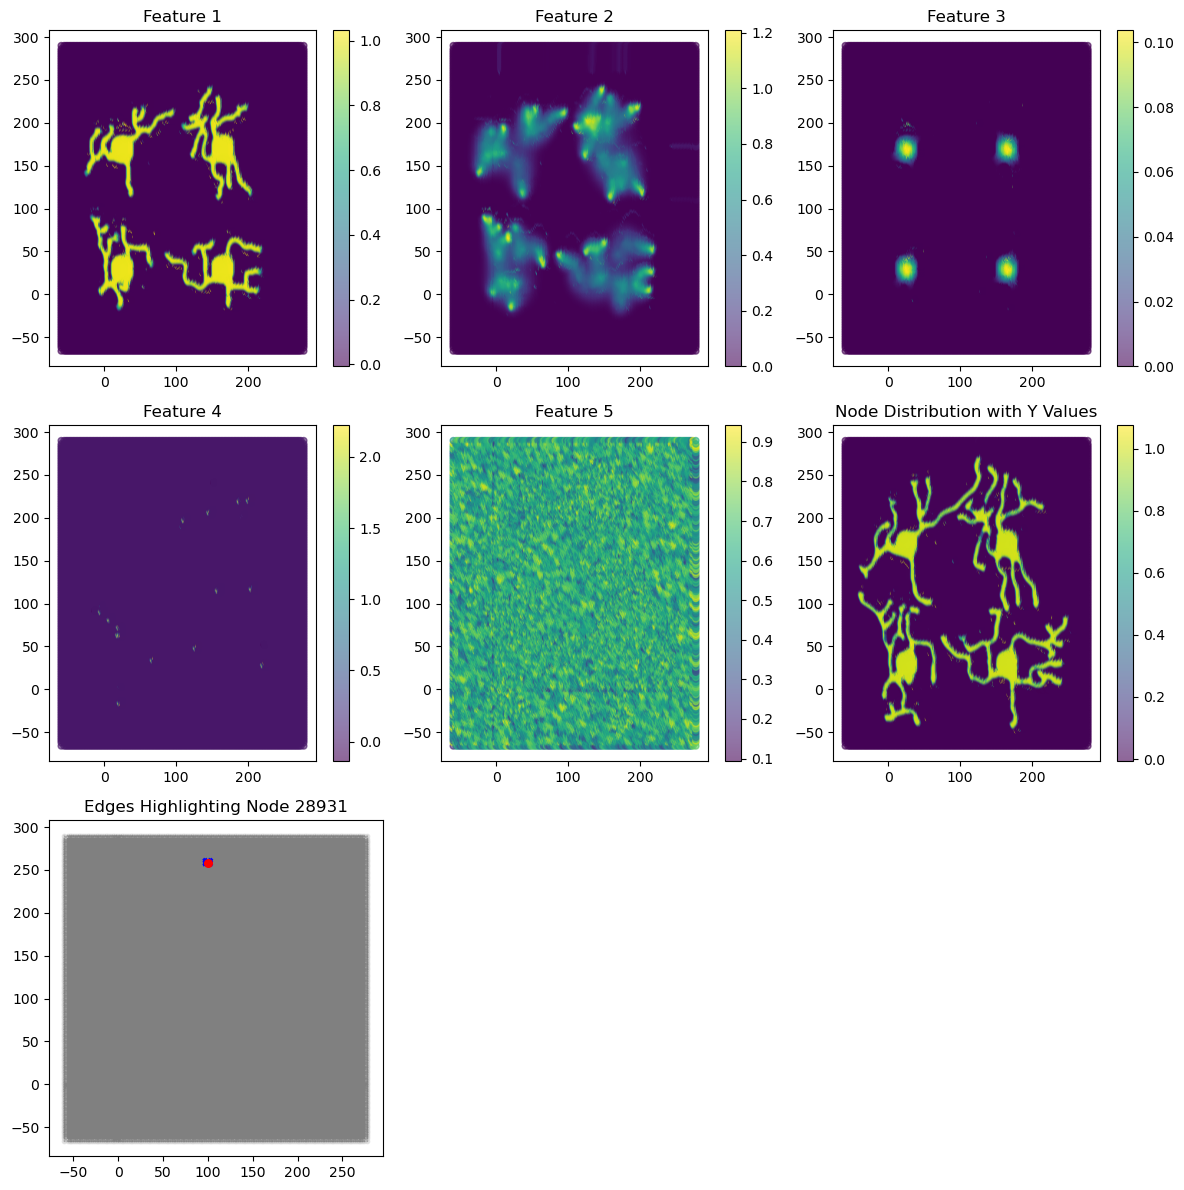

In [7]:
def plot_graph_components_with_highlights(points, features, edges, edge_attr, y):
    """
    Plots nodes and multiple scalar values in subplots, highlighting in blue the vectors (edges) originating from a randomly selected node,
    based on edge_index, using edge_attr to determine direction and magnitude, and also plots the y-values for each node.

    Args:
        points (numpy.ndarray): Nx2 array of point coordinates.
        features (numpy.ndarray): Array of multiple scalar values associated with each point, dimension NxM.
        edges (numpy.ndarray): Nx2 array of index pairs representing edges.
        edge_attr (torch.Tensor): Tensor containing lengths or vector components for each edge.
        y (numpy.ndarray): Array of scalar values associated with each point, typically used as target labels or another feature.
    """
    random_node = random.randint(0, len(points) - 1)
    num_features = features.shape[1]

    # Layout setup
    num_columns = 3
    num_rows = ((num_features + 2) + num_columns - 1) // num_columns
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(12, 4 * num_rows))
    axs = axs.ravel()

    # Plot node features
    for i in range(num_features):
        scatter = axs[i].scatter(points[:, 0], points[:, 1], c=features[:, i], cmap='viridis', s=20, alpha=0.6, zorder=1)
        axs[i].set_title(f'Feature {i+1}')
        fig.colorbar(scatter, ax=axs[i])

    # Plot y values
    scatter_y = axs[num_features].scatter(points[:, 0], points[:, 1], c=y, cmap='viridis', s=20, alpha=0.6, zorder=1)
    axs[num_features].set_title('Node Distribution with Y Values')
    fig.colorbar(scatter_y, ax=axs[num_features])

    # Prepare to plot edges
    edge_ax = axs[num_features + 1]
    edge_ax.scatter(points[:, 0], points[:, 1], c='lightgray', s=10, alpha=0.5, zorder=1)

    # Plot all edges with lower zorder
    for index, edge in enumerate(edges):
        point_a = points[edge[0]]
        point_b = points[edge[1]]
        dx = edge_attr[index][0]
        dy = edge_attr[index][1]
        edge_ax.plot([point_a[0], point_a[0]+dx], [point_a[1], point_a[1]+dy], color='gray', alpha=0.3, zorder=2, linewidth=1)

    # Plot connected edges last with higher zorder
    for index, edge in enumerate(edges):
        if random_node in edge:
            point_a = points[edge[0]]
            point_b = points[edge[1]]
            dx = edge_attr[index][0]
            dy = edge_attr[index][1]
            edge_ax.plot([point_a[0], point_a[0]+dx], [point_a[1], point_a[1]+dy], color='blue', zorder=3, linewidth=2)

    edge_ax.set_title(f'Edges Highlighting Node {random_node}')
    edge_ax.scatter(points[random_node, 0], points[random_node, 1], color='red', s=30, label='Random Node', zorder=4)
    # edge_ax.legend()

    # Hide any unused axes
    total_plots = num_features + 2
    for i in range(total_plots, len(axs)):
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

random_index = random.randint(0, len(graph_data_list) - 1)
graph_data = graph_data_list[random_index]
points = graph_data.x.numpy()[:, :2]
features = graph_data.x.numpy()[:, 2:]  # All features from index 2 to end
edges = graph_data.edge_index.numpy().T
edge_attr = graph_data.edge_attr.numpy()  # Assuming edge_attr contains vector components for each edge
y = graph_data.y.numpy()  # Assuming y contains target values or another feature for each node

plot_graph_components_with_highlights(points, features, edges, edge_attr, y)

In [8]:
def combine_graph_data(graph_data_list):
    """
    Combines multiple graph data objects into a single graph data object.

    Args:
        graph_data_list (list of Data): List of individual graph data objects to be combined.

    Returns:
        Data: A single combined graph data object containing all node features, edges, edge attributes, and target labels.
    """
    # Initialize lists to hold combined data components
    combined_x = []
    combined_edge_index = []
    combined_edge_attr = []
    combined_y = []
    
    node_offset = 0  # Initial offset for node indices

    # Loop through each individual graph data object
    for data in graph_data_list:
        num_nodes = data.x.size(0)  # Number of nodes in the current graph
        
        # Append node features from the current graph
        combined_x.append(data.x)
        
        # Adjust edge indices by the current node offset and append
        adjusted_edge_index = data.edge_index + node_offset
        combined_edge_index.append(adjusted_edge_index)
        
        # Append edge attributes from the current graph
        combined_edge_attr.append(data.edge_attr)
        
        # Append target labels from the current graph
        combined_y.append(data.y)
        
        # Update the node offset for the next graph
        node_offset += num_nodes
    
    # Concatenate lists into tensors to create a single combined graph
    combined_x = torch.cat(combined_x, dim=0)
    combined_edge_index = torch.cat(combined_edge_index, dim=1)
    combined_edge_attr = torch.cat(combined_edge_attr, dim=0)
    combined_y = torch.cat(combined_y, dim=0)
    
    # Create and return the combined Data object
    combined_data = Data(x=combined_x, edge_index=combined_edge_index, edge_attr=combined_edge_attr, y=combined_y)
    return combined_data

data = combine_graph_data(graph_data_list)
# data.x = data.x[:,:3]
# Print details about the combined graph data
print("Combined Graph Data:")
print(data)

Combined Graph Data:
Data(x=[550830, 7], edge_index=[2, 15101127], edge_attr=[15101127, 2], y=[550830])


In [9]:
if torch.isnan(data.x).any() or torch.isnan(data.y).any():
    print("NaNs found in the dataset")
if torch.isinf(data.x).any() or torch.isinf(data.y).any():
    print("Infs found in the dataset")

In [10]:
def remove_nodes(data, threshold=1e-2):
    """
    Removes nodes based on the condition that the third channel of x for the node and all its connected nodes 
    is close to 0 or close to 1 within a threshold.

    Args:
        data (Data): PyTorch Geometric Data object with attributes x, edge_index, y, and optionally edge_attr.
        threshold (float): Threshold value to determine closeness to zero or one.

    Returns:
        Data: A new PyTorch Geometric Data object with specified nodes removed.
    """
    num_nodes = data.x.size(0)
    # Create an adjacency list to find connected nodes easily
    adjacency_list = [[] for _ in range(num_nodes)]
    for source, target in data.edge_index.t().tolist():
        adjacency_list[source].append(target)
        adjacency_list[target].append(source)  # Assuming undirected graph

    # Check each node and its neighbors
    keep_nodes = torch.ones(num_nodes, dtype=torch.bool)
    # phi_values = data.x[:, 2]  # Assume the 'phi' feature is the third column in x
    phi_values = data.y  # Assume the 'phi' feature is the third column in x
    for idx in range(num_nodes):
        phi_node = phi_values[idx]
        neighbors_phi = phi_values[adjacency_list[idx]]
        # Check if node and all connected nodes are close to 0 or 1
        if not ((torch.abs(phi_node) <= threshold).item() or (torch.abs(phi_node - 1) <= threshold).item()):
            continue  # If central node phi is not close to 0 or 1, keep it
        if torch.all(torch.abs(neighbors_phi) <= threshold) or torch.all(torch.abs(neighbors_phi - 1) <= threshold):
            keep_nodes[idx] = False  # If all neighbors are also close to 0 or 1, mark for removal

    # Filter nodes, edges, and edge attributes
    new_x = data.x[keep_nodes]
    new_y = data.y[keep_nodes]
    kept_node_indices = torch.where(keep_nodes)[0]
    new_indices = torch.full((num_nodes,), -1, dtype=torch.long)
    new_indices[kept_node_indices] = torch.arange(kept_node_indices.size(0))

    # Filter edges to include only those connecting kept nodes
    edge_mask = (new_indices[data.edge_index[0]] != -1) & (new_indices[data.edge_index[1]] != -1)
    new_edge_index = new_indices[data.edge_index[:, edge_mask]]

    new_edge_attr = data.edge_attr[edge_mask] if data.edge_attr is not None else None

    # Create a new data object with the filtered data
    new_data = Data(x=new_x, edge_index=new_edge_index, y=new_y, edge_attr=new_edge_attr)
    return new_data

print('Before removing nodes based on phi values')
print(data)
data = remove_nodes(data, threshold=0.01)
print('After removing nodes based on phi values')
print(data)

Before removing nodes based on phi values
Data(x=[550830, 7], edge_index=[2, 15101127], edge_attr=[15101127, 2], y=[550830])
After removing nodes based on phi values
Data(x=[355647, 7], edge_index=[2, 12682730], edge_attr=[12682730, 2], y=[355647])


In [11]:
def remove_nans(data):
    # Verify and convert data types for NaN support if necessary
    data.x = data.x.float() if not data.x.is_floating_point() else data.x
    data.y = data.y.float() if not data.y.is_floating_point() else data.y

    # Check for NaNs in node features
    nan_nodes_x = torch.isnan(data.x).any(dim=1)
    print(f"NaNs in node features: {nan_nodes_x.sum().item()} found.")

    # Check for NaNs in labels, supports multidimensional labels
    nan_nodes_y = torch.isnan(data.y).any(dim=1) if data.y.dim() > 1 else torch.isnan(data.y)
    print(f"NaNs in labels: {nan_nodes_y.sum().item()} found.")

    # Combine conditions to identify all nodes with any NaN
    nan_nodes = nan_nodes_x | nan_nodes_y

    if nan_nodes.any():
        print("NaNs found in the dataset. Removing affected nodes.")
    else:
        print("No NaNs detected in the nodes.")

    # Filter out nodes with NaNs
    data.x = data.x[~nan_nodes]
    data.y = data.y[~nan_nodes]

    # Update edge_index if present, removing edges connected to NaN nodes
    if hasattr(data, 'edge_index'):
        edge_index = data.edge_index
        # Create a mask to keep edges where neither the source nor the target are NaN nodes
        mask = ~nan_nodes[edge_index[0]] & ~nan_nodes[edge_index[1]]
        data.edge_index = edge_index[:, mask]

    return data

print('Before removing NaN nodes')
print(data)
data = remove_nans(data)
print('After removing NaN nodes')
print(data)

Before removing NaN nodes
Data(x=[355647, 7], edge_index=[2, 12682730], edge_attr=[12682730, 2], y=[355647])
NaNs in node features: 0 found.
NaNs in labels: 0 found.
No NaNs detected in the nodes.
After removing NaN nodes
Data(x=[355647, 7], edge_index=[2, 12682730], edge_attr=[12682730, 2], y=[355647])


In [12]:
# Ensure y (labels) is of shape [num_nodes]
data.y = data.y.view(-1)  # Ensure y is 1D [num_nodes]

# Number of nodes in the graph
num_nodes = data.x.size(0)  # Infer the number of nodes from x
num_train = int(num_nodes * 0.8)  # 80% of nodes for training
num_test = num_nodes - num_train  # 20% of nodes for testing

# Randomly permute node indices to create random train, validation, and test splits
perm = torch.randperm(num_nodes)

# Initialize masks for train and test sets
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# Assign masks based on the random permutation
train_mask[perm[:num_train]] = True
test_mask[perm[num_train:]] = True

# Assign masks to the Data object
data.train_mask = train_mask
data.test_mask = test_mask

# Optional: Create a validation mask from the training set
num_val = int(num_train * 0.1)  # 10% of the training set for validation
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask[perm[:num_val]] = True

# Assign validation mask to the Data object
data.val_mask = val_mask

data.num_classes = 2  # Assuming your problem is binary classification

data.y = data.y.float()
# Print the final structured data object
print(data)

Data(x=[355647, 7], edge_index=[2, 12682730], edge_attr=[12682730, 2], y=[355647], train_mask=[355647], test_mask=[355647], val_mask=[355647], num_classes=2)


In [13]:
def min_max_normalize_features(x):
    """
    Normalizes each feature in the x tensor to be between 0 and 1.

    Args:
        x (torch.Tensor): A tensor of shape [N, F] where N is the number of nodes and F is the number of features.

    Returns:
        torch.Tensor: The normalized feature tensor.
    """
    min_vals = torch.min(x, dim=0)[0]
    max_vals = torch.max(x, dim=0)[0]
    range_vals = max_vals - min_vals
    range_vals[range_vals == 0] = 1  # Prevent division by zero to handle features that are constant
    normalized_x = (x - min_vals) / range_vals

    return normalized_x

def add_gradient_features(data, edge_index):
    """
    Adds gradient features to the data.x tensor based on the differences in feature values along edges.
    The gradient is calculated using the pseudo-coordinates stored in edge_attr and added to the node features.

    Args:
        data (torch_geometric.data.Data): The data object containing node features and edge attributes.
        edge_index (torch.Tensor): Tensor containing the indices of source and destination nodes for each edge.

    Returns:
        data (torch_geometric.data.Data): The modified data object with additional gradient features.
    """
    num_features = data.x.shape[1] - 2  # Exclude the coordinate columns
    epsilon = 1e-6  # Small number to prevent division by zero

    for i in range(num_features):
        feature_values = data.x[:, i+2]
        gradients = torch.zeros_like(data.x[:, :2])  # Only two columns for gradient (dx, dy)

        for j, (src, dest) in enumerate(edge_index.t()):
            pseudo_coords = data.edge_attr[j]
            dx, dy = pseudo_coords[0], pseudo_coords[1]  # Assuming pseudo_coords are stored as [dx, dy]

            # Calculate gradient components separately and safely
            gradient_x = (feature_values[dest] - feature_values[src]) / (dx + epsilon)
            gradient_y = (feature_values[dest] - feature_values[src]) / (dy + epsilon)
            
            gradients[src, 0] += gradient_x
            gradients[src, 1] += gradient_y
            gradients[dest, 0] -= gradient_x
            gradients[dest, 1] -= gradient_y

        # Concatenate gradient features to original features
        data.x = torch.cat([data.x, gradients], dim=1)

        print(f"Processed feature {i+1}/{num_features} ({(i+1) / num_features * 100:.1f}%)")

    return data

def rotate_points(data, angle_degrees):
    """
    Rotates the point coordinates in the data.x tensor by a specified angle.

    Args:
        data (torch_geometric.data.Data): The data object containing node features.
        angle_degrees (float): The angle in degrees to rotate the point coordinates.

    Returns:
        data (torch_geometric.data.Data): The modified data object with rotated coordinates.
    """
    angle = np.radians(angle_degrees)
    rotation_matrix = np.array([
        [np.cos(angle), -np.sin(angle)],
        [np.sin(angle), np.cos(angle)]
    ])

    # Assume the first two columns in x are coordinates
    coords = data.x[:, :2].numpy()
    new_coords = np.dot(coords, rotation_matrix)
    data.x[:, :2] = torch.tensor(new_coords, dtype=torch.float32)

    print(f"Rotated points by {angle_degrees} degrees.")
    return data

def oversample_minority_class(data):
    """
    Duplicates samples of the minority class in the dataset to balance class distribution.

    Args:
        data (torch_geometric.data.Data): The data object containing node labels and optionally masks.

    Returns:
        data (torch_geometric.data.Data): The modified data object with duplicated minority class samples.
    """
    unique, counts = torch.unique(data.y, return_counts=True)
    minority_class = unique[torch.argmin(counts)]

    # Indices of the minority class
    minority_indices = (data.y == minority_class).nonzero(as_tuple=True)[0]
    
    # Duplicate minority class samples
    minority_x = data.x[minority_indices]
    minority_y = data.y[minority_indices]
    
    # Update the data object
    data.x = torch.cat([data.x, minority_x], dim=0)
    data.y = torch.cat([data.y, minority_y], dim=0)

    # Update masks if they exist
    if hasattr(data, 'train_mask'):
        minority_mask = data.train_mask[minority_indices]
        data.train_mask = torch.cat([data.train_mask, minority_mask], dim=0)
    if hasattr(data, 'test_mask'):
        minority_mask = data.test_mask[minority_indices]
        data.test_mask = torch.cat([data.test_mask, minority_mask], dim=0)
    if hasattr(data, 'val_mask'):
        minority_mask = data.val_mask[minority_indices]
        data.val_mask = torch.cat([data.val_mask, minority_mask], dim=0)
    
    print(f"Duplicating node {idx.item()} for minority class ({minority_class}); Progress: {len(data.y) / len(minority_indices) * 100:.1f}%")
    return data

In [14]:
# Normalize features
data.x = min_max_normalize_features(data.x)
data.edge_attr = min_max_normalize_features(data.edge_attr)
data.y = min_max_normalize_features(data.y)

# # Add gradient features
# data = add_gradient_features(data, data.edge_index)
# print('Done adding gradient features')

# # Optionally, rotate points for augmentation
# data = rotate_points(data, 45)  # Rotate by 45 degrees
# print('Done rotating points')

# # Oversample minority class to balance the dataset
# data = oversample_minority_class(data)
# print('Done oversampling minority class')

# Print data to verify changes
print(data)

Data(x=[355647, 7], edge_index=[2, 12682730], edge_attr=[12682730, 2], y=[355647], train_mask=[355647], test_mask=[355647], val_mask=[355647], num_classes=2)


In [15]:
# Assuming `graph_data_list` is already created
torch.save(data, './generated_data/data.pth')
# Load the graph data list
data = torch.load('./generated_data/data.pth')

C:\Users\Kuanr\AppData\Local\Temp\ipykernel_33420\2346118849.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load('./generated_data/data.pth')


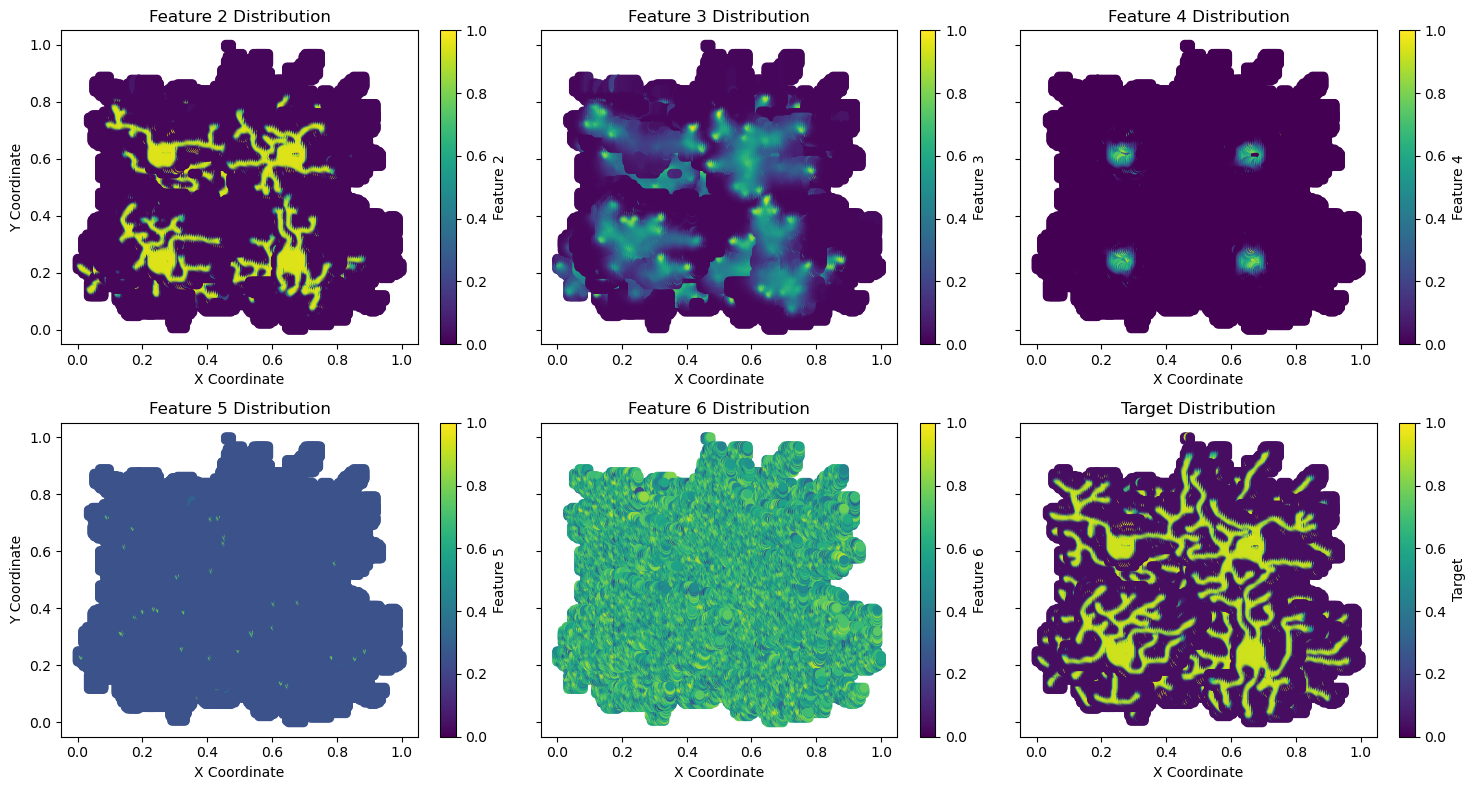

In [16]:
def plot_features_and_target(data):
    """
    Plots each feature and the target variable from the dataset based on the coordinates.

    Args:
        data (torch_geometric.data.Data): The data object containing node features, where
            the first two columns are assumed to be x and y coordinates.

    Displays:
        Scatter plots for each feature and the target variable, colored by their values.
    """
    if data.x is None or data.y is None:
        print("Node features or target values are missing in the dataset.")
        return

    # Coordinates are the first two columns
    coords = data.x[:, :2].numpy()
    num_features = data.x.size(1) - 2  # excluding the coordinate columns

    # Setup plot grid
    num_plots = num_features + 1  # Plus one for the target variable
    cols = 3  # Set number of columns for subplots
    rows = (num_plots + cols - 1) // cols  # Calculate the required number of rows

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), sharey=True, squeeze=False)

    # Plot each feature
    for i in range(num_plots):
        ax = axes[i // cols, i % cols]  # Determine row and column index
        if i < num_features:
            sc = ax.scatter(coords[:, 0], coords[:, 1], c=data.x[:, i+2].numpy(), cmap='viridis', s=35)
            fig.colorbar(sc, ax=ax, label=f'Feature {i+2}')
            ax.set_title(f'Feature {i+2} Distribution')
        else:
            # Plot the target variable
            sc = ax.scatter(coords[:, 0], coords[:, 1], c=data.y.numpy(), cmap='viridis', s=35)
            fig.colorbar(sc, ax=ax, label='Target')
            ax.set_title('Target Distribution')

        ax.set_xlabel('X Coordinate')
        if i % cols == 0:  # Only set y-label on the first column
            ax.set_ylabel('Y Coordinate')

    # Hide empty subplots if any
    for j in range(i + 1, rows * cols):
        fig.delaxes(axes[j // cols, j % cols])

    plt.tight_layout()
    plt.show()

plot_features_and_target(data)

Data(x=[355647, 7], edge_index=[2, 12682730], edge_attr=[12682730, 2], y=[355647], train_mask=[355647], test_mask=[355647], val_mask=[355647], num_classes=2)
tensor(1.)
tensor([[6.8571e-02, 4.3617e-01, 1.5927e-02,  ..., 8.6654e-04, 2.5000e-01,
         5.5688e-01],
        [6.8571e-02, 4.3883e-01, 1.5927e-02,  ..., 8.6654e-04, 2.5000e-01,
         3.8818e-01],
        [6.8571e-02, 4.4149e-01, 1.5927e-02,  ..., 8.6654e-04, 2.5000e-01,
         4.1471e-01],
        ...,
        [8.9714e-01, 7.0745e-01, 1.5928e-02,  ..., 8.6654e-04, 2.5000e-01,
         5.3249e-01],
        [8.9714e-01, 7.1011e-01, 1.5928e-02,  ..., 8.6654e-04, 2.5000e-01,
         6.0315e-01],
        [8.9714e-01, 7.1277e-01, 1.5928e-02,  ..., 8.6654e-04, 2.5000e-01,
         6.1147e-01]])
tensor(1.)
tensor([0.0330, 0.0332, 0.0333,  ..., 0.0331, 0.0331, 0.0331])
Randomly selected data.y values:
Index 24692: 0.9131084084510803
Index 173197: 0.03314032405614853
Index 273106: 0.033280640840530396
Index 140861: 0.03308847919

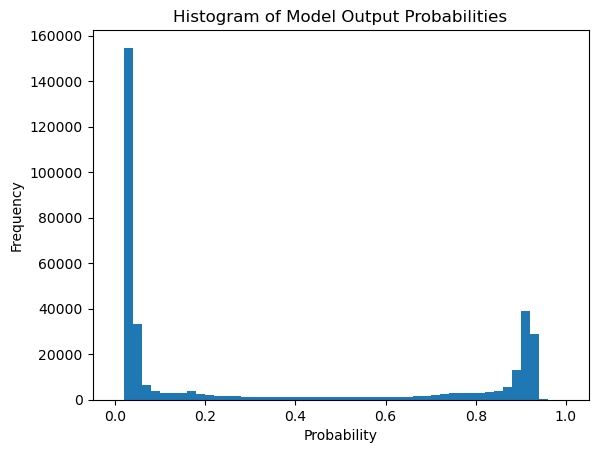

In [17]:
# Example check for NaNs in your data
if torch.isnan(data.x).any() or torch.isnan(data.y).any():
    print("NaNs found in the dataset")

# !mkdir ./generated_data
# # Assuming 'data' is your PyTorch Geometric Data object
# torch.save(data, './generated_data/NDD.pt')
# # Load a single data object
# data = torch.load('./generated_data/NDD_per1000.pt')

print(data)
print(max(data.x[:,2]))
print(data.x)
print(max(data.y))
print(data.y)

def print_random_y_values(data):
    """
    Randomly selects and prints 10 values from the data.y tensor.

    Args:
        data (torch_geometric.data.Data): The data object containing the y attribute
            which is a tensor of shape [N] where N is the number of elements.

    """
    num_samples = 20  # Number of samples to print
    num_elements = data.y.size(0)  # Total number of elements in data.y

    # Ensure we don't sample more elements than available
    if num_elements < num_samples:
        num_samples = num_elements

    # Randomly choose indices without replacement
    indices = torch.randperm(num_elements)[:num_samples]

    # Fetch the selected elements
    selected_values = data.y[indices]

    # Print the selected values
    print("Randomly selected data.y values:")
    for index, value in zip(indices, selected_values):
        print(f'Index {index.item()}: {value.item()}')

print_random_y_values(data)

plt.hist(data.y.numpy(), bins=50)
plt.title('Histogram of Model Output Probabilities')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()


In [18]:
class Net(torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self.conv1 = SplineConv(dataset.num_features, 32, dim=2, kernel_size=4, is_open_spline=True, degree=3, aggr="max", root_weight=True, bias=True)
        self.bn1 = torch.nn.BatchNorm1d(32)
        self.conv2 = SplineConv(32, 64, dim=2, kernel_size=4, is_open_spline=True, degree=3, aggr="max", root_weight=True, bias=True)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.conv3 = SplineConv(64, 128, dim=2, kernel_size=4, is_open_spline=True, degree=3, aggr="max", root_weight=True, bias=True)
        self.bn3 = torch.nn.BatchNorm1d(128)
        self.conv4 = SplineConv(128, 1, dim=2, kernel_size=4, is_open_spline=True, degree=3, aggr="max", root_weight=True, bias=True)
        self.bn4 = torch.nn.BatchNorm1d(64)
        # self.conv5 = SplineConv(64, 1, dim=2, kernel_size=4, is_open_spline=True, degree=2, aggr="add", root_weight=True, bias=True)
        # self.bn5 = torch.nn.BatchNorm1d(1)
        self.fc = torch.nn.Linear(1,1)


    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.dropout(x, training=self.training, p=0.1)
        x = self.conv1(x, edge_index, edge_attr)
        x = self.bn1(x)
        x = F.elu(x)
        x = F.dropout(x, training=self.training, p=0.1)
        x = self.conv2(x, edge_index, edge_attr)
        x = self.bn2(x)
        x = F.elu(x)
        x = F.dropout(x, training=self.training, p=0.1)
        x = self.conv3(x, edge_index, edge_attr)
        x = self.bn3(x)
        x = F.dropout(x, training=self.training, p=0.1)
        x = self.conv4(x, edge_index, edge_attr)
        x = F.elu(x)
        # x = self.fc(x)  # Linear layer for adjusting outputs before final activation
        x = torch.sigmoid(x)  # Sigmoid activation to output probabilities
        return x

class SplineCNN_SuperPixelNet(torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()
        # First SplineConv layer
        self.conv1 = SplineConv(dataset.num_features, 32, dim=2, kernel_size=4, is_open_spline=True, degree=2, aggr="add", root_weight=True, bias=True)
        self.bn1 = torch.nn.BatchNorm1d(32)
        self.pool1 = torch.nn.MaxPool2d(4)  # Pooling layers might not be directly applicable depending on your graph structure

        # Second SplineConv layer
        self.conv2 = SplineConv(32, 64, dim=2, kernel_size=4, is_open_spline=True, degree=2, aggr="add", root_weight=True, bias=True)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.pool2 = torch.nn.MaxPool2d(4)

        # Global Average Pooling
        self.glob_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))  # Adjusted to graph's pooled feature dimensions

        # Fully connected layers
        self.fc1 = torch.nn.Linear(64, 128)
        self.fc2 = torch.nn.Linear(128, 1)

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        
        # First SplineConv layer
        x = self.conv1(x, edge_index, edge_attr)
        x = self.bn1(x)
        x = F.elu(x)
        # Note: MaxPool2d is not directly applicable to graph data without a spatial feature representation

        # Second SplineConv layer
        x = self.conv2(x, edge_index, edge_attr)
        x = self.bn2(x)
        x = F.elu(x)
        # Note: Again, MaxPool2d is not directly applicable here

        # Adjust pooling here to match graph data requirements
        # x = self.glob_avg_pool(x)  # Needs to be adapted if x is not a batched feature map

        # Flatten the output for the fully connected layers
        x = torch.flatten(x, 1)
        
        # Fully connected layers
        x = F.elu(self.fc1(x))
        x = self.fc2(x)

        return x

from torch_geometric.nn import GCNConv

class GCNNet(torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, 32)
        self.bn1 = torch.nn.BatchNorm1d(32)
        self.conv2 = GCNConv(32, 64)
        self.bn2 = torch.nn.BatchNorm1d(64)
        self.conv3 = GCNConv(64, 128)
        self.bn3 = torch.nn.BatchNorm1d(128)
        self.conv4 = GCNConv(128, 1)
        # Define more layers as needed, using torch.nn for any necessary components.

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, training=self.training, p=0.1)
        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.elu(x)
        
        x = F.dropout(x, training=self.training, p=0.1)
        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.elu(x)
        
        x = F.dropout(x, training=self.training, p=0.1)
        x = self.conv3(x, edge_index)
        x = self.bn3(x)
        x = F.elu(x)
        
        x = F.dropout(x, training=self.training, p=0.1)
        x = self.conv4(x, edge_index)
        x = F.elu(x)
        
        x = torch.sigmoid(x)  # Use sigmoid for binary classification problems
        return x

from torch_geometric.nn import GATConv
class GATNet(torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self.conv1 = GATConv(dataset.num_features, 32, heads=8, dropout=0.6)
        self.conv2 = GATConv(32 * 8, 64, heads=8, dropout=0.6)  # Adjust according to your model setup
        self.conv3 = GATConv(64 * 8, 128, heads=8, dropout=0.6)
        self.conv4 = GATConv(128 * 8, 1, heads=1, concat=False, dropout=0.6)  # Ensuring single output per node
        self.fc = torch.nn.Linear(1, 1)
    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv3(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv4(x, edge_index)
        # x = self.fc(x) 
        x = torch.sigmoid(x)  # or no activation if purely regression without bounded output
        return x

In [19]:
class HybridGAT_SplineNet(torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()
        # Initialize GATConv with attention mechanism
        self.gat1 = GATConv(dataset.num_features, 32, heads=8, dropout=0.6)
        
        # Initialize SplineConv for capturing complex patterns with spline kernels
        self.spline1 = SplineConv(32 * 8, 64, dim=2, kernel_size=5, aggr='max')
        
        # Another layer of GATConv to focus on attention-based feature refinement
        self.gat2 = GATConv(64, 64, heads=8, dropout=0.6, concat=True)
        
        # Final SplineConv layer for detailed feature extraction before output
        self.spline2 = SplineConv(64 * 8, 1, dim=2, kernel_size=5, aggr='max')
        
        self.dropout_rate = 0.6

    def forward(self, data):
        x, edge_index, pseudo = data.x, data.edge_index, data.edge_attr
        # Ensure pseudo coordinates are provided for SplineConv layers
        
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.gat1(x, edge_index)
        x = F.elu(x)

        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.spline1(x, edge_index, pseudo)
        x = F.elu(x)

        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.gat2(x, edge_index)
        x = F.elu(x)
        
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.spline2(x, edge_index, pseudo)

        x = torch.sigmoid(x)  # Assuming binary classification or sigmoid needed for final output
        return x

In [20]:
# def train():
#     model.train()
#     optimizer.zero_grad()
#     out = model(data)
#     loss = F.mse_loss(out[data.train_mask], data.y[data.train_mask].unsqueeze(1))  # Use MSE loss for continuous output
#     loss.backward()
    
#     torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#     optimizer.step()

# @torch.no_grad()
# def test():
#     model.eval()
#     out = model(data)  # Output shape: [num_nodes, 1]
#     out = out.squeeze()  # Squeeze to match target shape [num_nodes]

#     train_error = F.mse_loss(out[data.train_mask], data.y[data.train_mask]).item()
#     test_error = F.mse_loss(out[data.test_mask], data.y[data.test_mask]).item()
    
#     return train_error, test_error

def train():
    model.train()
    optimizer.zero_grad()

    # Get the model output
    out = model(data)

    # Ensure the output is between 0 and 1 by applying a sigmoid, if not already included in the model
    out_prob = torch.sigmoid(out[data.train_mask])

    # Ensure the target labels are of the correct shape [num_nodes, 1] and type float
    target = data.y[data.train_mask].unsqueeze(1).float()

    # Use binary cross-entropy loss
    loss = F.binary_cross_entropy(out_prob, target)

    # Perform backpropagation and an optimization step
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()


@torch.no_grad()
def test():
    model.eval()

    # Get the model output
    out = model(data)

    # Ensure the output is between 0 and 1 by applying a sigmoid
    out_prob = torch.sigmoid(out)

    # Calculate binary cross-entropy loss for train and test sets
    train_loss = F.binary_cross_entropy(out_prob[data.train_mask], data.y[data.train_mask].unsqueeze(1).float()).item()
    test_loss = F.binary_cross_entropy(out_prob[data.test_mask], data.y[data.test_mask].unsqueeze(1).float()).item()

    return train_loss, test_loss


In [21]:
from torch_geometric.nn import GCNConv

class ResidualGCNBlock(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, out_channels)
        self.conv2 = GCNConv(out_channels, out_channels)
        if in_channels != out_channels:
            self.projection = torch.nn.Linear(in_channels, out_channels)
        else:
            self.projection = None

    def forward(self, x, edge_index):
        identity = x
        out = F.relu(self.conv1(x, edge_index))
        out = self.conv2(out, edge_index)
        
        if self.projection is not None:
            identity = self.projection(identity)
        
        out += identity  # Residual connection
        out = F.relu(out)
        return out

class ResidualGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3, dropout=0.5):
        super().__init__()
        self.initial_conv = GCNConv(in_channels, hidden_channels)
        self.res_blocks = torch.nn.ModuleList([ResidualGCNBlock(hidden_channels, hidden_channels) for _ in range(num_layers - 1)])
        self.final_conv = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.initial_conv(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        
        for block in self.res_blocks:
            x = block(x, edge_index)
            x = F.dropout(x, p=self.dropout, training=self.training)
        
        x = self.final_conv(x, edge_index)
        return x

# def train(model, data, optimizer):
#     model.train()
#     optimizer.zero_grad()
#     out = model(data)  # Shape should be [number of nodes, 1] for regression
#     out = out[data.train_mask]  # Applying mask
#     targets = data.y[data.train_mask].float()  # Ensure targets are float for MSE loss
#     loss = F.mse_loss(out, targets)  # Use MSE loss for continuous output
#     loss.backward()
#     optimizer.step()
#     return loss.item()

# def accuracy(output, labels, threshold=0.1):
#     """Calculate accuracy within a given threshold."""
#     return (output.sub(labels).abs() < threshold).float().mean().item()

# def evaluate(model, data):
#     model.eval()
#     with torch.no_grad():
#         out = model(data).squeeze()  # Squeeze to remove extra dimension from output

#         train_masked_out = out[data.train_mask]
#         test_masked_out = out[data.test_mask]
#         train_labels = data.y[data.train_mask].float()
#         test_labels = data.y[data.test_mask].float()

#         train_acc = accuracy(train_masked_out, train_labels)
#         test_acc = accuracy(test_masked_out, test_labels)

#         return train_acc, test_acc

# # Setup for model training/testing
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = ResidualGCN(data.num_node_features, 64, 1, num_layers=3).to(device)  # Assuming the output is 1 for regression
# data = data.to(device)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# # Lists to store training and test accuracy for each epoch
# train_acc_list = []
# test_acc_list = []

# # Example training loop
# for epoch in range(1, 101):
#     train_loss = train(model, data, optimizer)
#     train_acc, test_acc = evaluate(model, data)
#     train_acc_list.append(train_acc)
#     test_acc_list.append(test_acc)
#     print(f'Epoch {epoch}: Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')



In [22]:
# check and printout device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

print(data)

# GPU Memory Monitoring Function
def print_gpu_memory(device):
    torch.cuda.synchronize(device)
    allocated = torch.cuda.memory_allocated(device)
    reserved = torch.cuda.memory_reserved(device)
    print(f"Allocated memory: {allocated / (1024**3):.3f} GB")
    print(f"Reserved memory: {reserved / (1024**3):.3f} GB")

# Initialize the Net model
# model = SplineCNN_SuperPixelNet(data)
# model = Net(data)  # Instantiate the model with the data
# model = GCNNet(data)
# model = GATNet(data)
model = HybridGAT_SplineNet(data)

# Initialize weights
def weights_init(m):
    # Check if the module has 'weight' attribute
    if hasattr(m, 'weight') and hasattr(m.weight, 'data'):
        # Apply Xavier uniform initialization
        torch.nn.init.xavier_uniform_(m.weight.data)
    # If the module has a bias attribute, initialize it as zeros
    if hasattr(m, 'bias') and m.bias is not None:
        torch.nn.init.constant_(m.bias.data, 0.0)

# Apply the weights initialization
model.apply(weights_init)

# Move to the appropriate device
model = model.to(device)
data = data.to(device)

# Set up the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)

# Lists to store training and test accuracy for each epoch
train_acc_list = []
test_acc_list = []

for epoch in range(1, 501):
    train()
    train_acc, test_acc = test()
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Test: {test_acc:.4f}')
    if epoch % 20 == 0:
        print_gpu_memory(torch.device('cuda:0'))

cuda
Data(x=[355647, 7], edge_index=[2, 12682730], edge_attr=[12682730, 2], y=[355647], train_mask=[355647], test_mask=[355647], val_mask=[355647], num_classes=2)


OutOfMemoryError: CUDA out of memory. Tried to allocate 12.44 GiB. GPU 0 has a total capacity of 8.00 GiB of which 0 bytes is free. Of the allocated memory 14.96 GiB is allocated by PyTorch, and 265.00 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Plot the convergence of training and test accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, 501), train_acc_list, label='Train Accuracy')
plt.plot(range(1, 501), test_acc_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Convergence Plot')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
@torch.no_grad()
def evaluate_model_regression(data, model):
    model.eval()
    out = model(data)
    
    actual = data.y[data.test_mask]
    print(actual.size())
    
    # # Calculate Mean Squared Error
    # mse = F.mse_loss(out[data.test_mask], actual)
    # print(f'Test MSE: {mse.item():.4f}')

    # Ensure output is within the [0, 1] range using sigmoid (if not already applied in the model)
    out_prob = torch.sigmoid(out[data.test_mask]).squeeze()  # Apply sigmoid to ensure the outputs are probabilities.
    # Calculate Binary Cross-Entropy
    bce = F.binary_cross_entropy(out_prob, actual)
    print(f'Test BCE: {bce.item():.4f}')

    # Print sample predictions for checking
    print("\nSample Predictions:")
    num_samples = min(10, out[data.test_mask].size(0))
    for i in range(num_samples):
        print(f'Predicted: {out[data.test_mask][i].item():.4f}, Actual: {actual[i].item():.4f}')

evaluate_model_regression(data, model)


In [ ]:
@torch.no_grad()
def evaluate_model_regression(data, model):
    model.eval()
    out = model(data)
    
    actual = data.y[data.test_mask]
    print(actual.size())
    
    # Ensure output is within the [0, 1] range using sigmoid (if not already applied in the model)
    out_prob = torch.sigmoid(out[data.test_mask]).squeeze()  # Apply sigmoid to ensure the outputs are probabilities.
    
    # Calculate Binary Cross-Entropy
    bce = F.binary_cross_entropy(out_prob, actual)
    print(f'Test BCE: {bce.item():.4f}')

    # Calculate accuracy for the entire test dataset
    # predicted_labels = (out_prob > 0.7).int()  # Apply threshold to convert probabilities to binary labels
    predicted_labels = out_prob  # Apply threshold to convert probabilities to binary labels
    correct_predictions = (predicted_labels == actual).float().sum().item()  # Calculate the number of correct predictions
    total_predictions = actual.size(0)  # Total number of predictions
    accuracy = correct_predictions / total_predictions  # Calculate accuracy
    print(f'Test Accuracy: {accuracy:.4f}')

    # Print sample predictions for checking
    print("\nSample Predictions:")
    num_samples = min(20, actual.size(0))  # Limit number of samples to print
    if num_samples > 0:
        sample_indices = torch.randperm(actual.size(0))[:num_samples]  # Randomly pick indices to print
        for i in sample_indices:
            predicted_label = predicted_labels[i].item()
            out_prob_val = out_prob[i].item()
            actual_val = actual[i].item()
            print(f'Pred label: {predicted_label}, Out prob: {out_prob_val:.4f}, Actual: {actual_val:.0f}')

    plt.hist(out_prob.detach().cpu().numpy(), bins=50)
    plt.title('Histogram of Model Output Probabilities')
    plt.xlabel('Probability')
    plt.ylabel('Frequency')
    plt.show()

evaluate_model_regression(data, model)


In [ ]:
@torch.no_grad()
def evaluate_model(data, model, rotation_angle_degrees=-45, num_samples=100):
    model.eval()
    out = model(data)
    
    # Get all test indices
    test_indices = torch.where(data.test_mask)[0]
    
    # Randomly sample from the test indices if the number is greater than num_samples
    if len(test_indices) > num_samples:
        sampled_indices = test_indices[torch.randperm(len(test_indices))[:num_samples]]
    else:
        sampled_indices = test_indices

    # out_prob = torch.sigmoid(out[sampled_indices].squeeze())  # Apply sigmoid to ensure the outputs are probabilities
    # threshold = 0.7  # Define the threshold
    # pred = (out_prob > threshold).int()  # Convert probabilities to binary labels based on the threshold
    pred = torch.sigmoid(out[sampled_indices].squeeze())
    actual = data.y[sampled_indices]
    input_phi = data.x[sampled_indices, 2]  # Assuming the third column is phi
    error = (pred - actual).abs()  # Calculate error as absolute difference

    # # Calculate accuracy for the sampled cases
    # correct = pred.round().eq(actual.round()).sum().item()
    # total = len(sampled_indices)
    # accuracy = correct / total
    # print(f'Test Accuracy (sampled): {accuracy:.4f} for {num_samples} samples')

    # Reverse the rotation for visualization purposes
    angle = np.radians(rotation_angle_degrees)
    rotation_matrix = np.array([
        [np.cos(angle), np.sin(angle)],
        [-np.sin(angle), np.cos(angle)]
    ])

    coords = data.x[sampled_indices][:, :2].cpu().numpy()  # Ensure the first two columns are coordinates
    new_coords = np.dot(coords, rotation_matrix)

    # Visualization of 2D predictions
    fig, ax = plt.subplots(1, 4, figsize=(28, 7), sharex=True, sharey=True)
    scatter = ax[0].scatter(new_coords[:, 0], new_coords[:, 1], c=input_phi.cpu().numpy(), cmap='viridis', s=50)
    ax[0].set_title('Input Phi')
    ax[0].set_xlabel('X Coordinate')
    ax[0].set_ylabel('Y Coordinate')
    plt.colorbar(scatter, ax=ax[0], label='Input Phi Value')

    scatter = ax[1].scatter(new_coords[:, 0], new_coords[:, 1], c=pred.cpu().numpy(), cmap='viridis', s=50)
    ax[1].set_title('Predicted Phi')
    ax[1].set_xlabel('X Coordinate')
    plt.colorbar(scatter, ax=ax[1], label='Predicted Class')

    scatter = ax[2].scatter(new_coords[:, 0], new_coords[:, 1], c=actual.cpu().numpy(), cmap='viridis', s=50)
    ax[2].set_title('Actual Phi')
    ax[2].set_xlabel('X Coordinate')
    plt.colorbar(scatter, ax=ax[2], label='Actual Class')

    # Error visualization
    scatter = ax[3].scatter(new_coords[:, 0], new_coords[:, 1], c=error.cpu().numpy(), cmap='viridis', s=50)
    ax[3].set_title('Absolute error')
    ax[3].set_xlabel('X Coordinate')
    plt.colorbar(scatter, ax=ax[3], label='Error')

    plt.show()

evaluate_model(data, model, 0, num_samples=1000)
